This is for random test

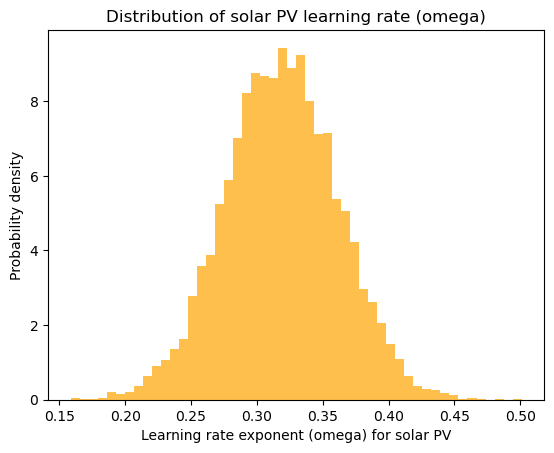

In [2]:
import numpy as np
import matplotlib.pyplot as plt

omega_mean = 0.319  # costparams['omega']['solar pv electricity']
omega_std = 0.043   # costparams['sigmaOmega']['solar pv electricity']

samples = np.random.normal(omega_mean, omega_std, size=10000)

plt.hist(samples, bins=50, density=True, alpha=0.7, color='orange')
plt.xlabel('Learning rate exponent (omega) for solar PV')
plt.ylabel('Probability density')
plt.title('Distribution of solar PV learning rate (omega)')
plt.show()

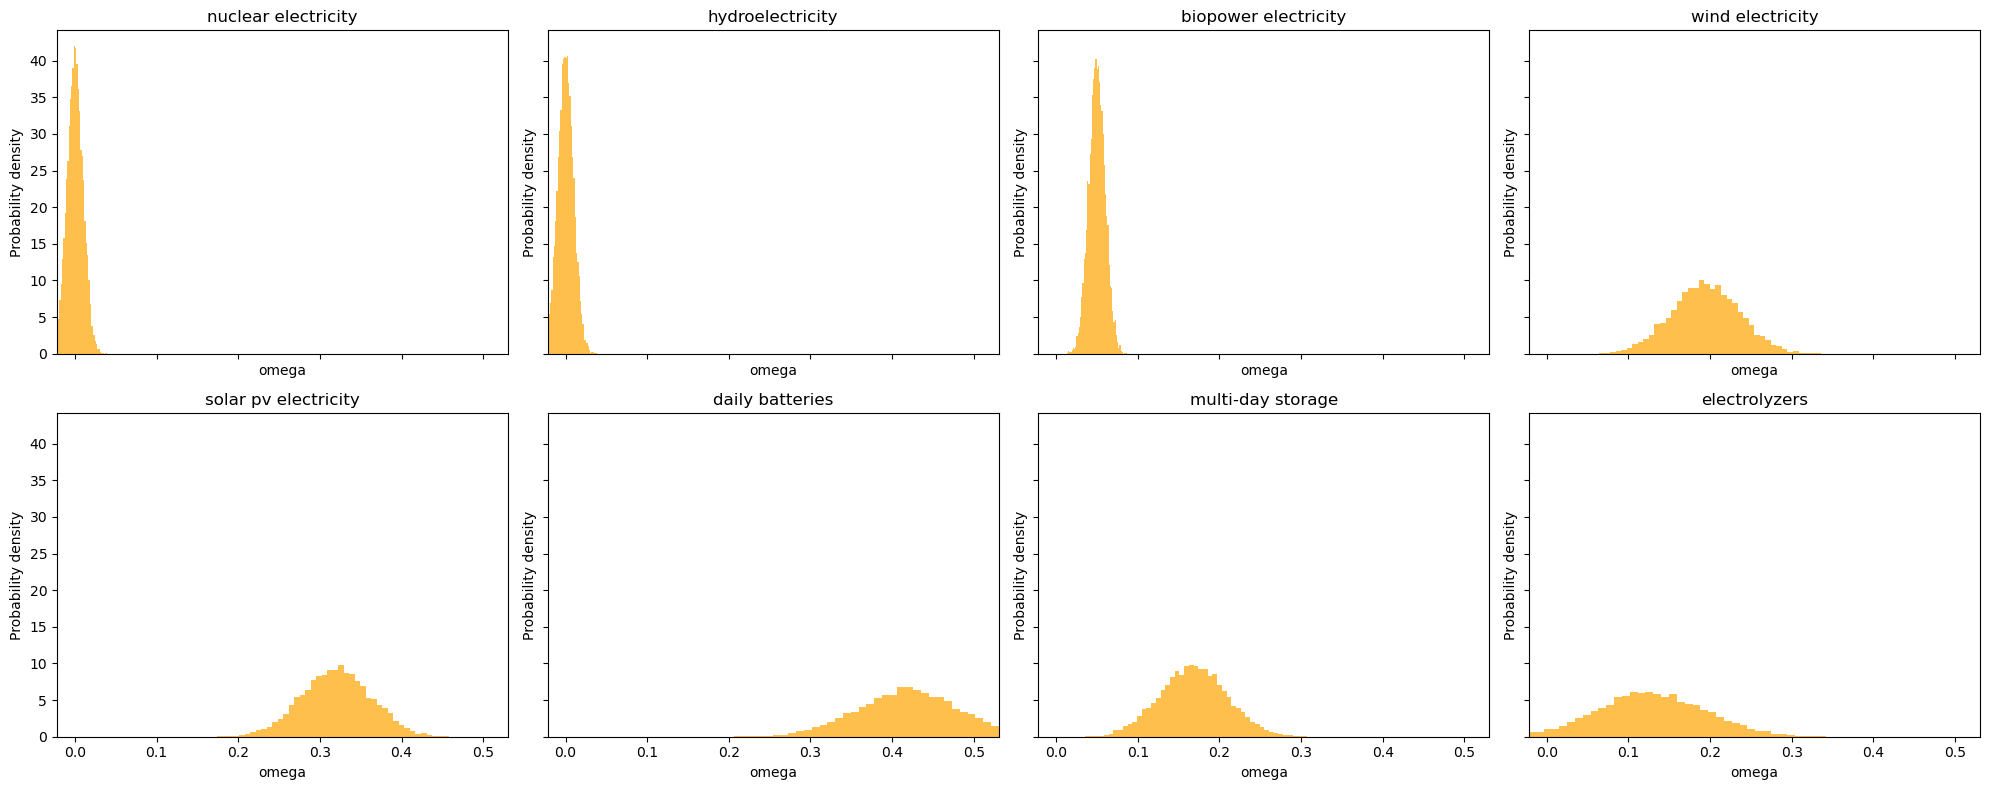

In [3]:
techs = [
    'nuclear electricity', 'hydroelectricity', 'biopower electricity',
    'wind electricity', 'solar pv electricity', 'daily batteries',
    'multi-day storage', 'electrolyzers'
]

omega_means = [
    0.0, 0.0, 0.05, 0.194, 0.319, 0.421, 0.168, 0.129
]
omega_stds = [
    0.01, 0.01, 0.01, 0.041, 0.043, 0.063, 0.041, 0.067
]

# Generate samples for each technology
samples_dict = {
    tech: np.random.normal(mu, sigma, size=10000)
    for tech, mu, sigma in zip(techs, omega_means, omega_stds)
}

# Find global x and y limits
all_samples = np.concatenate(list(samples_dict.values()))
x_min, x_max = np.percentile(all_samples, [0.5, 99.5])
y_max = 0
for s in samples_dict.values():
    counts, bins = np.histogram(s, bins=50, density=True)
    y_max = max(y_max, counts.max())

# Plot
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()
for i, tech in enumerate(techs):
    axes[i].hist(samples_dict[tech], bins=50, density=True, alpha=0.7, color='orange')
    axes[i].set_title(tech)
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(0, y_max * 1.05)
    axes[i].set_xlabel('omega')
    axes[i].set_ylabel('Probability density')
plt.tight_layout()
plt.show()

In [43]:
import numpy as np

label = '090301'
data = np.load(f"results/figures/{label}/objective_vs_iteration.npy")
print(data)

[3.81233350e+17 3.81234606e+17 3.77812883e+17 ... 1.95450048e+14
 1.80119901e+14 1.85336383e+14]


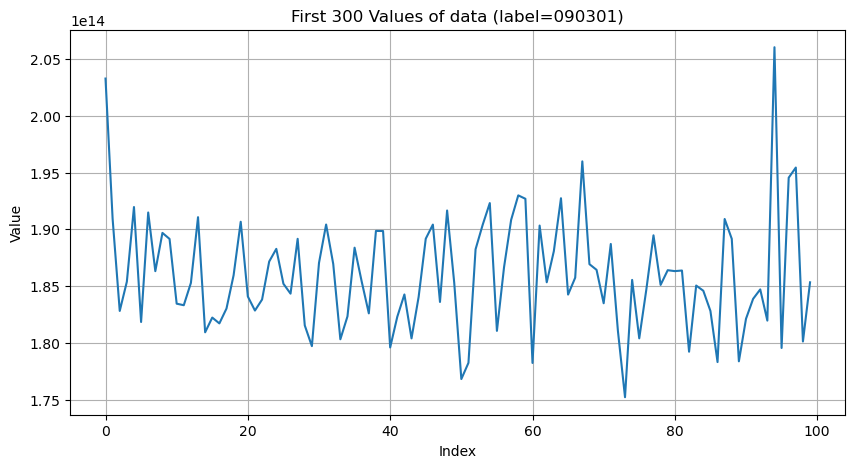

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(data[-100:])
plt.title(f'First 300 Values of data (label={label})')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib, os
import energySim._energy_sim_model as _energy_sim_model
import energySim._energy_sim_params as _energy_sim_params
import numpy as np

: 

In [2]:

nsim =100
label = '081401'
sim_scenario = 'fast transition'



# create labels for different cost assumptions
labels = ['Way et al. (2022)']

# define colors for technologies
techcolors = ['black', 'saddlebrown', 'darkgray', 'saddlebrown', 'darkgray',
              'magenta', 'royalblue', 'forestgreen', 'deepskyblue',
              'orange', 'pink', 'plum', 'lawngreen', 'burlywood'] 

np.random.seed(0)

# create dictionary to store total costs
tcosts = {}

# for each label, create an empty dictionary to store costs
for l in labels:
    tcosts[l] = {}
    tcosts[l+' - decision rule'] = {}

# create empty list to store technology expansion
techExp = []

# iterate over scenarios
for scenario in _energy_sim_params.scenarios.keys():

    if 'historical' in scenario or 'nuclear' in scenario:
        continue

    # create empty list to store total costs
    for l in labels:
        tcosts[l][scenario] = []
        tcosts[l+' - decision rule'][scenario] = []

    # pass input data to model
    print("building the model...")
    model = _energy_sim_model.EnergyModel(\
                EFgp = _energy_sim_params.scenarios[scenario][0],
                slack = _energy_sim_params.scenarios[scenario][1],
                costparams = _energy_sim_params.costsAssumptions['Way et al. (2022)'],
                gt_clip = 0.3, hidden_size = 16, input_norm = False)

    ######## simulate model



    # set policy mode
    model.mode = 'policy'

    # load policy file
    #model.policy.load('energySim' + os.path.sep + 'fast_transition_policy_new.pth')
    policy_path = f'results/{label}_{sim_scenario}_policy.pth'
    model.policy.load(policy_path)
    # run multiple iterations to explore cost parameters' uncertainty
    np.random.seed(0)
    all_shares = []
    for n in range(nsim):

        all_inputs = []
        for sim in range(nsim):
            model.sample_uncertainties()
            model.y = model.y0
            inputs_this_sim = []
            while model.y < model.yend:
                for t in [model.technology[x] for x in model.carrierInputs[model.carrier.index('electricity')]]:
                    pol_input = [
                        np.log10(model.c[t][model.y-model.y0]),
                        np.log10(model.z[t][model.y-model.y0])/10,
                        (model.y-model.y0)/(model.yend-model.y0),
                        10*(sum([model.q[model.technology[x]][model.y-model.y0]
                            for x in model.carrierInputs[model.carrier.index('electricity')]])
                            / model.elec[model.y-model.y0] - 1),
                        model.q[t][model.y-model.y0]/model.elec[model.y-model.y0]
                    ]
                    inputs_this_sim.append(pol_input)
                model.y += 1
            all_inputs.extend(inputs_this_sim)
        all_inputs = np.array(all_inputs)
        means = np.mean(all_inputs, axis=0)
        stds = np.std(all_inputs, axis=0)
        print("Policy input means:", means)
        print("Policy input stds:", stds)




NameError: name 'np' is not defined